# Saturation Demo

In this notebook, we demonstrate a very quick and lightweight example that shows how to use attribution priors. It should take only a minute or two to run on CPU on any standard laptop. This notebook also demonstrates the benefit of an _axiomatic_ feature attribution method for use with attribution priors. Since our expected gradients explainer is able to overcome saturation, it can fix the spurious correlation. Regularizing the input gradients fails.

### imports

In [1]:
from attributionpriors.pytorch_ops_cpu import AttributionPriorExplainer

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import random


import os
from tqdm import *

import sys
sys.path.insert(0, '../')

np.random.seed(1017)
random.seed(1017)

import torch
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

### define data

Define a toy dataset with two features $x_1$ and $x_2$. In the training data, $x_1$ and $x_2$ are perfectly correlated. In the test data, they are uncorrelated. We want to model a third variable that is defined $y$ = $x_1$

In [3]:
class BinaryData(Dataset):
    
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [4]:
a = torch.empty(10000,1).uniform_(0, 1)
x = torch.bernoulli(a)
x_train = torch.cat([x,x],axis=1)

a_test = torch.empty(10000,2).uniform_(0, 1)
x_test = torch.bernoulli(a_test)

y_train = x_train[:,0]
y_test = x_test[:,0]

In [5]:
train_dataset = BinaryData(x_train,y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32*2*2, shuffle=True,drop_last=True)

test_dataset = BinaryData(x_test,y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32*2*2, shuffle=True,drop_last=True)

### define a model

We can then initialize a neural network that might have been trained on this data, which depends on both features (since they are perfectly correlated in the training data, the model could depend on both equally).

In [6]:
##
## While this is obviously a trivial network, it makes training quick on CPU and helps illustrate the point
##

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
                    torch.nn.Linear(2, 1),
                    torch.nn.Sigmoid()
                )
    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
##
## Initialize an MLP that depends equally on both features
##

model = MLP()
with torch.no_grad():
    model.layers[0].weight[0, 0] = 10.
    model.layers[0].weight[0, 1] = 10.
    model.layers[0].bias[0] = -6.

## plot decision surface

When we visualize the decision surface for this network, we see that it depends equally on $x_1$ (the true feature) and $x_2$ (the spurious correlate). Hence, it will get poor performance on the test data.

In [8]:
##
## Code to plot model's decision surface
##

def green_gold_r():
    """
    Colormap for plotting.
    """
    import matplotlib as mpl
    color_map_size = 256
    vals = np.ones((color_map_size, 4))
    vals[:, 0] = np.linspace(20/256, 250/256, color_map_size)
    vals[:, 1] = np.linspace(125/256, 230/256, color_map_size)
    vals[:, 2] = np.linspace(0/256, 0/256, color_map_size)
    cmap = mpl.colors.ListedColormap(vals)
    return cmap

def generate_output_matrix():
    x1_range = np.linspace(-0.1, 1.1, num=50)
    x2_range = np.linspace(-0.1, 1.1, num=50)
    output_mat = np.zeros((x1_range.size, x2_range.size))

    for i,x1 in enumerate(x1_range):
        for j,x2 in enumerate(x2_range):
            output_mat[i,j] = model(torch.tensor([x1,x2]).view(1,-1))

    return output_mat,x1_range,x2_range

import numpy.matlib as mat
def plot_output():
    output_mat,x1_range,x2_range = generate_output_matrix()
    x1_m = mat.repmat(x1_range, x2_range.size, 1)
    x2_m = mat.repmat(x2_range, x1_range.size, 1).T
    figsize = (10,10)
    fig1 = plt.figure(0, figsize=figsize)
    ax11 = fig1.add_subplot(111,projection='3d')
    
    p1 = ax11.plot_surface(x1_m, x2_m, output_mat,
            cmap=green_gold_r(),alpha=0.85)
    ax11.set_ylabel('x1')
    ax11.set_xlabel('x2')
    ax11.set_zlabel('y')
    plt.show()

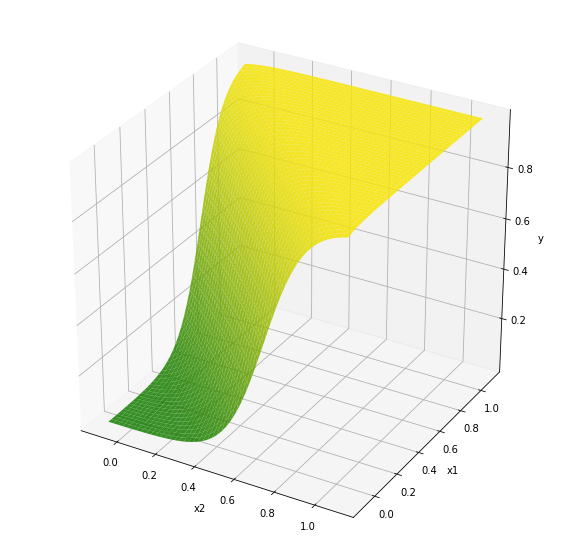

In [9]:
##
## We can see that the model's output (y) depends on both features (x1 and x2)

plot_output()

In [10]:
##
## Define a background distribution (in this case the all-0s distribution will suffice)
## and initialize Expected Gradients explainer
##

x_zeros = torch.zeros_like(x)
background_dataset = BinaryData(x_zeros,y_train)

APExp = AttributionPriorExplainer(background_dataset, 32*2*2,k=70)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
mse_term = torch.nn.MSELoss()

In [12]:
mean_train_losses = []
mean_valid_losses = []

for epoch in range(8):
    model.train()
    
    train_losses = []
    valid_losses = []
    
    # train
    for i, (features, labels) in tqdm(enumerate(train_loader)):
        features, labels = features.float(), labels.float()
        optimizer.zero_grad()
        
        outputs = model(features)
        
        ## get attributions
        eg = APExp.shap_values(model,features)
        ## get the average magnitude of the attributions
        ma_eg = eg.abs().mean(0)
        ## penalize the average magnitude of the attributions for feature $x_2$
        loss = ma_eg[1].abs()
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())
                    
    mean_train_losses.append(np.mean(train_losses))
        
    print(epoch,np.mean(train_losses))


78it [00:11,  7.08it/s]
1it [00:00,  7.36it/s]

0 0.24621214335545516


78it [00:10,  7.32it/s]
1it [00:00,  6.04it/s]

1 0.22460668342999923


78it [00:10,  7.36it/s]
1it [00:00,  6.59it/s]

2 0.20490495975200945


78it [00:10,  7.45it/s]
1it [00:00,  7.47it/s]

3 0.18506845717246717


78it [00:11,  7.08it/s]
1it [00:00,  7.22it/s]

4 0.1637973733819448


78it [00:10,  7.39it/s]
1it [00:00,  7.59it/s]

5 0.14389145154601488


78it [00:10,  7.34it/s]
1it [00:00,  7.46it/s]

6 0.12076477534495868


78it [00:10,  7.33it/s]

7 0.09710182555210896


After 8 epochs of penalizing the attributions for the spurious correlation, we see that the model no longer depends on $x_2$!

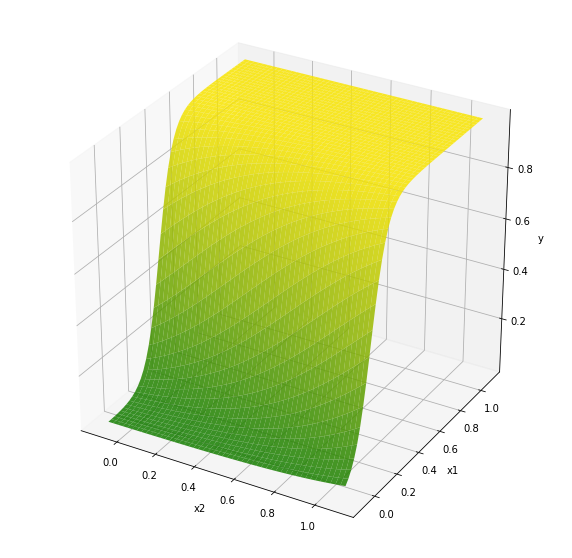

In [13]:
##
## We can see that the model's output (y) now depends solely on feature x1

plot_output()

## demonstrate that this doesn't work w/ input gradients

We can also use this notebook to demonstrate the shortcomings of regularizing other attribution methods. When we look at the decision surface of the original (unregularized) model, we can see that the gradients will be saturated on the data manifold since the function is flat at (0,0), (0,1), (1,0), and (1,1). When we try to regularize the gradients during training, it doesn't change the decision surface of a model.

In [14]:
from torch.autograd import grad

In [15]:
##
## re-initialize model

model = MLP()
with torch.no_grad():
    model.layers[0].weight[0, 0] = 10.
    model.layers[0].weight[0, 1] = 10.
    model.layers[0].bias[0] = -6.

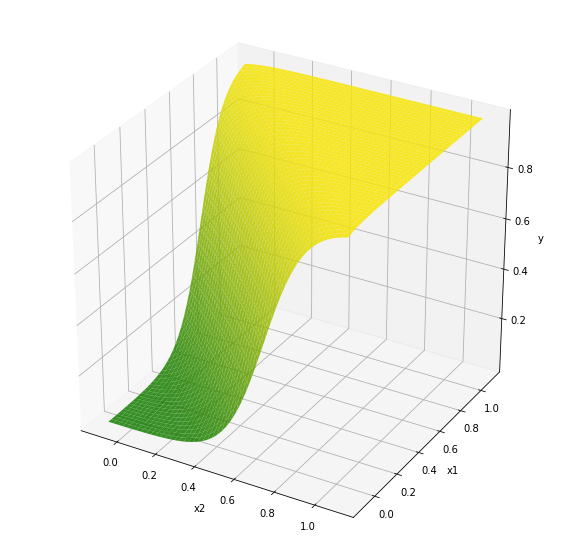

In [16]:
plot_output()

In [17]:
mean_train_losses = []
mean_valid_losses = []

for epoch in range(8):
    model.train()
    
    train_losses = []
    valid_losses = []
    
    # train
    for i, (features, labels) in tqdm(enumerate(train_loader)):
        features, labels = features.float(), labels.float()
        features.requires_grad = True

        optimizer.zero_grad()
        
        outputs = model(features)
        inp_grad = grad(outputs=outputs,
                    inputs=features,
                    grad_outputs=torch.ones_like(outputs),
                    create_graph=True)[0]
        ma_ig = inp_grad.abs().mean(0)
        loss = ma_ig[1].abs()
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
        
    print(epoch,np.mean(train_losses))

78it [00:00, 453.82it/s]
78it [00:00, 522.34it/s]
0it [00:00, ?it/s]

0 0.012087293805029148
1 0.012082354547694707


78it [00:00, 465.70it/s]
78it [00:00, 501.51it/s]
0it [00:00, ?it/s]

2 0.012074945661693048
3 0.012087293805029148


78it [00:00, 455.98it/s]
78it [00:00, 473.77it/s]
0it [00:00, ?it/s]

4 0.012087293805029148
5 0.012082354547694707


78it [00:00, 449.44it/s]
78it [00:00, 492.81it/s]

6 0.012087293805029148
7 0.012079884919027487


After 8 epochs of penalizing the gradients for the spurious correlation, we see that the model still depends on $x_2$!

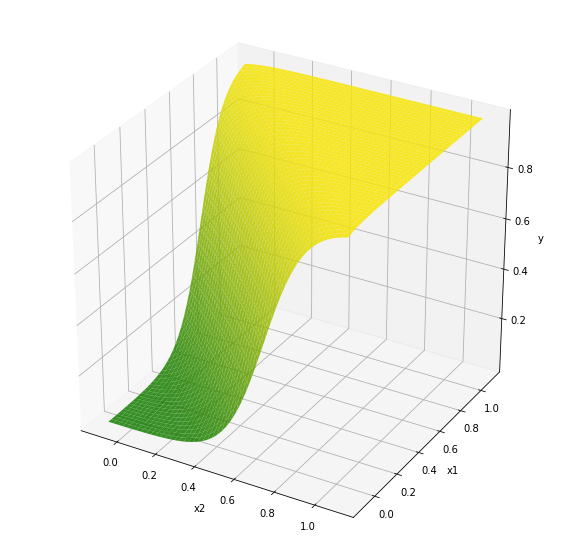

In [18]:
plot_output()